# Feature Extraction

## 0. Preparation

In [32]:
from google.colab import drive
import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

In [33]:
print("matplotlib: {}".format(matplotlib.__version__))
print("numpy: {}".format(np.__version__))
print("cv2: {}".format(cv2.__version__))

matplotlib: 3.7.1
numpy: 1.23.5
cv2: 4.8.0


In [2]:
PATH = '/content/drive/MyDrive/McGill/ECSE415/Assignment2'
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Harris Corner Detection

Functions Defined:
*   non_max_suppression(img, wsize=3)
*   get_cornerness_matrix(Ix, Iy, k)
*   get_derivative(img)




In [3]:
def non_max_suppression(img, wsize=3):
  height, width = img.shape
  nms = np.zeros((height, width))
  offset = wsize // 2 #how far from the edge of the image we should start and end the scanning

  for i in range(offset, height - offset):
    for j in range(offset, width - offset):
      #if the current pixel is the maximum value of all the values inside the window, keep the value
      if img[i,j] == np.max(img[i-offset:i+offset+1, j-offset:j+offset+1]):
        nms[i,j] = img[i,j]
  return nms

In [4]:
def get_cornerness_matrix(Ix, Iy, k):
  height, width = Ix.shape
  cornerness = np.zeros((height, width), dtype=np.float64)

  for i in range(1, height - 2):
    for j in range(1, width - 2):
      window_Ix = Ix[i - 1:i + 2, j - 1:j + 2]
      window_Iy = Iy[i - 1:i + 2, j - 1:j + 2]

      H = np.zeros((2, 2))
      H[0, 0] = np.sum(window_Ix ** 2)
      H[0, 1] = H[1, 0] = np.sum(window_Ix * window_Iy)
      H[1, 1] = np.sum(window_Iy ** 2)

      detH = np.linalg.det(H)
      traceH = np.trace(H)
      cornerness[i, j] = detH - k * (traceH ** 2)

  return cornerness

In [5]:
def get_derivative(img):
  gradX = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
  gradY = cv2.Sobel(img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
  mag = cv2.magnitude(gradX, gradY)
  phase = cv2.phase(gradX, gradY)
  return gradX, gradY, mag, phase



---



Harris corner detector on Checkerboard

In [6]:
img = cv2.imread(PATH + "/data/Q1/checkerboard.png") #values: 0-255
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_smooth = cv2.GaussianBlur(img_gray, (3,3), 0)

img_gradX, img_gradY, img_mag, img_phase = get_derivative(img_smooth)
img_gradX = cv2.GaussianBlur(img_gradX, (3,3), 0)
img_gradY = cv2.GaussianBlur(img_gradY, (3,3), 0)

cornerness = get_cornerness_matrix(img_gradX, img_gradY, 0.05)
cornerness_normalized = cv2.normalize(cornerness, None, 0, 1, cv2.NORM_MINMAX) #values normalized to 0-1
cornerness_suppressed = non_max_suppression(cornerness_normalized, wsize=5)

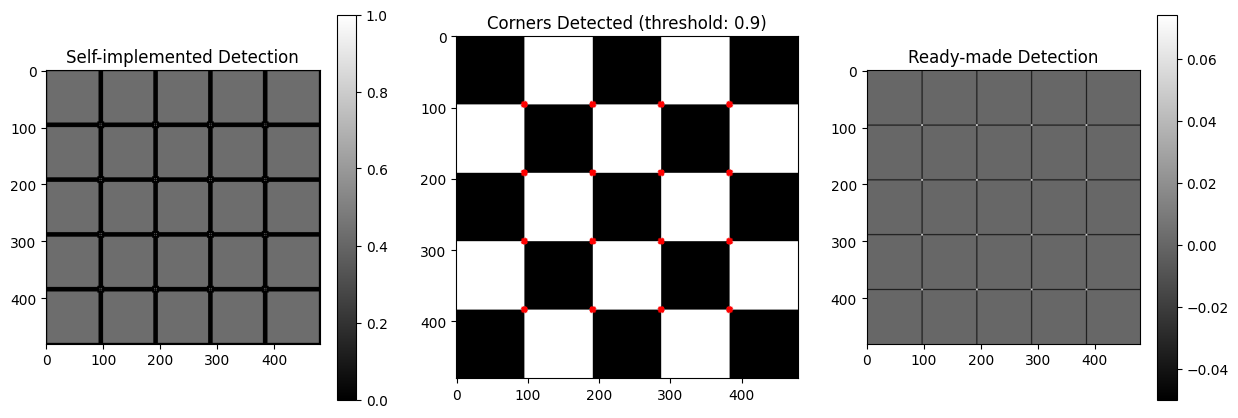

In [7]:
#plotting cornerness map produced by self-implemented detection algorithm
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
subplot0 = ax[0].imshow(cornerness_suppressed, cmap="gray")
ax[0].set_title("Self-implemented Detection")
fig.colorbar(subplot0, ax=ax[0])


#plotting original checkerboard with red dots indicating corners
img_temp = img.copy()
threshold = 0.9 #all values above this is considered a corner
loc = np.where(cornerness_suppressed >= threshold)
for pt in zip(*loc[::-1]):
    cv2.circle(img_temp, pt, 3, (255,0,0), -1)

ax[1].imshow(img_temp, cmap="gray")
ax[1].set_title(f"Corners Detected (threshold: { threshold })")


#plotting cornerness map produced by ready-made detection algorithm
corners = cv2.cornerHarris(img_gray, 2, 3, 0.05)
subplot2 = ax[2].imshow(corners, cmap="gray")
ax[2].set_title("Ready-made Detection")
fig.colorbar(subplot2, ax=ax[2])

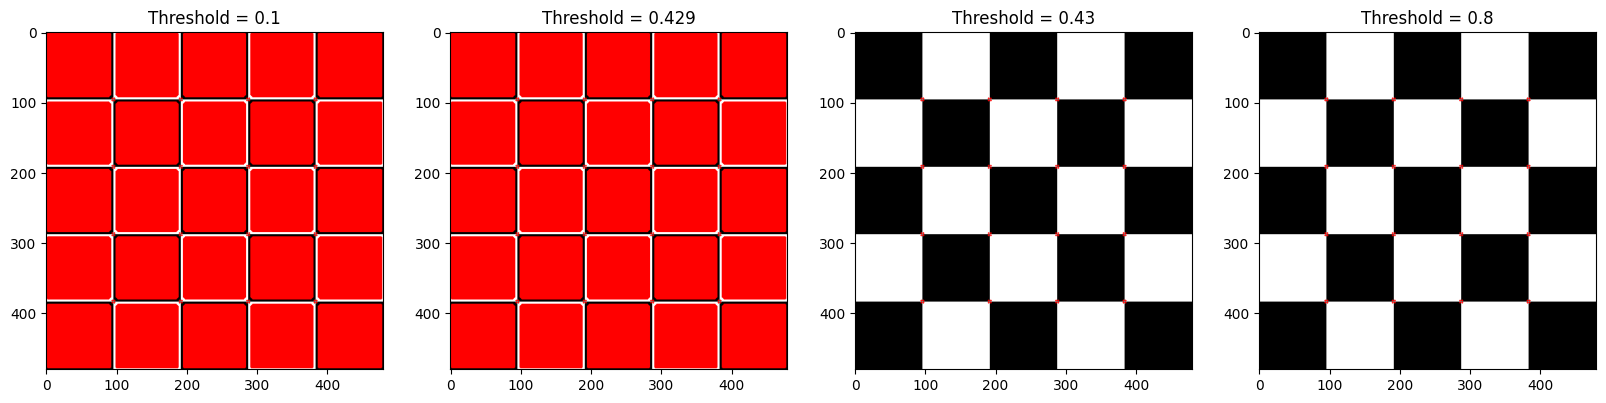

In [8]:
thresholds = [0.1, 0.429, 0.430, 0.8]
fig, ax = plt.subplots(1, 4, figsize=(20,20))
for i, thr in enumerate(thresholds):
  img_temp = img.copy()
  corners = non_max_suppression(cornerness_normalized, wsize=5)
  loc = np.where(corners >= thr) #locating indices of pixels where the value is above the threshold "thr"

  #drawing red circles on corners
  for pt in zip(*loc[::-1]):
    cv2.circle(img_temp, pt, 1, (255,0,0), -1)

  ax[i].imshow(img_temp, cmap="gray")
  ax[i].set_title("Threshold = " + str(thr))

**Observations**

The corners of the checkerboard were correctly detected when the threshold was set above 0.43. When the threshold was below this value, the flat areas were also colored in red.

The harris corner response (R) indicates the following
*   Corner: if R > 0 and |R| is large
*   Edge: if R < 0 and |R| is large
*   Flat: if |R| is small

Therefore, when the harris corner response matrix is normalized to values between 0 and 1, the values indicate in order, edges, flat areas, corners from 0 to 1. This is why the flat areas started to get colored in red when the threshold was decremented.



---


Harris corner detector on Courthouse

In [9]:
img = cv2.imread(PATH + "/data/Q1/courthouse_gray.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_smooth = cv2.GaussianBlur(img_gray, (3,3), 0)

img_gradX, img_gradY, img_mag, img_phase = get_derivative(img_smooth)
img_gradX = cv2.GaussianBlur(img_gradX, (3,3), 0)
img_gradY = cv2.GaussianBlur(img_gradY, (3,3), 0)

cornerness = get_cornerness_matrix(img_gradX, img_gradY, 0.05)
cornerness_normalized = cv2.normalize(cornerness, None, 0, 1, cv2.NORM_MINMAX) #values normalized to 0-1
cornerness_suppressed = non_max_suppression(cornerness_normalized, wsize=7)

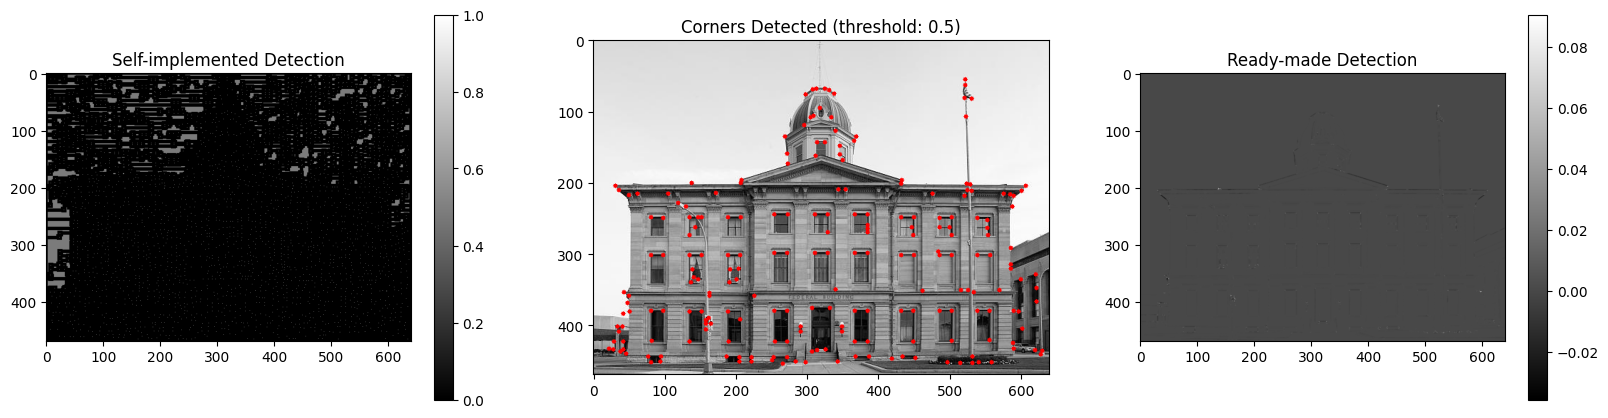

In [10]:
#plotting cornerness map produced by self-implemented detection algorithm
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
subplot0 = ax[0].imshow(cornerness_suppressed, cmap="gray")
ax[0].set_title("Self-implemented Detection")
fig.colorbar(subplot0, ax=ax[0])


#plotting original checkerboard with red dots indicating corners
threshold = 0.5 #all values above this is considered a corner
loc = np.where(cornerness_suppressed >= threshold)
for pt in zip(*loc[::-1]):
    cv2.circle(img, pt, 3, (255,0,0), -1)

ax[1].imshow(img, cmap="gray")
ax[1].set_title(f"Corners Detected (threshold: { threshold })")


#plotting cornerness map produced by ready-made detection algorithm
corners = cv2.cornerHarris(img_gray, 2, 3, 0.05)
subplot2 = ax[2].imshow(corners, cmap="gray")
ax[2].set_title("Ready-made Detection")
fig.colorbar(subplot2, ax=ax[2])

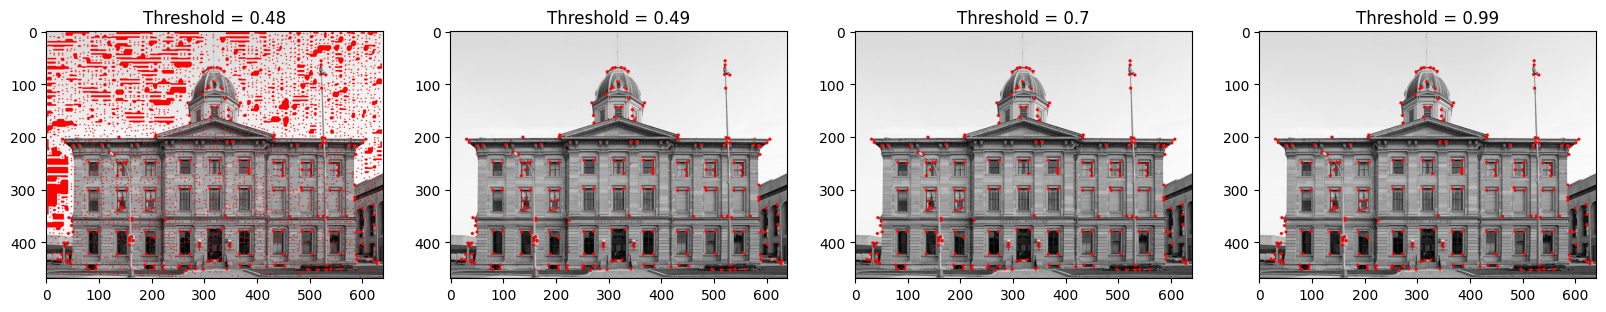

In [11]:
thresholds = [0.48, 0.49, 0.7, 0.99]
fig, ax = plt.subplots(1, 4, figsize=(20,20))
for i, thr in enumerate(thresholds):
  img_temp = img.copy()
  corners = non_max_suppression(cornerness_normalized, wsize=7)
  loc = np.where(corners > thr) #locating indices of pixels where the value is above the threshold "thr"

  #drawing red circles on corners
  for pt in zip(*loc[::-1]):
    cv2.circle(img_temp, pt, 1, (255,0,0), -1)

  ax[i].imshow(img_temp, cmap="gray")
  ax[i].set_title("Threshold = " + str(thr))

**Observations**

The corners were detected at a certain level above the threshold value of 0.49. Below this threshold, the flat areas especially the sky was marked with red circles. When increasing the threshold, there is no significant loss in detected corners, which infers that the high values considered as corners are clustered close to 1.


When observing the individual window frames, the bottom corners of the windows on the second floor to the right where not detected. It can be thought that there was not a significant texture difference between the window glass and the frame. In addition, there is a lighting tendency where the shadows are nont projected clearly on the bottom corners of the windows compared to the top corners.


When lowering the threshold, a strange pattern of red markers in the sky was shown. This maybe due to the noise of the camera and there may be horizontal and vertical strokes that cannot be clearly observed by the human eye. In order to prevent this, a Gaussian filtering with larger windows or other filters such as mode filtering may be effective. However, this is not of great importance since these points can be discarded by thresholding.

## 2. SIFT Features

### 2.1 SIFT in a nutshell

**Step1.**

Create a Gaussian Pyramid, where each layer is filtered with a Gaussian Pyramid with different σ values and generate a DoG Pyramid by subtracting one layer of the Gaussian Pyramid from the layer below it.


**Step2.**

Detect the local maxima/minima of the DoG Pyramid by iterating through each pixel and checking all of it's neighbours and the layer above and below it.


**Step 3.**

Discard keypoints with maximum DoG value below some threshold and keypoints along edges. The latter is done by looking for corners and removing edge features.


**Step 4.**

For each keypoint, collect gradient directions and magnitudes, and figure out the most prominent orientation by selecting the canonical orientation from a histogram of local gradient directions.

### 2.2 SIFT between two different pictures

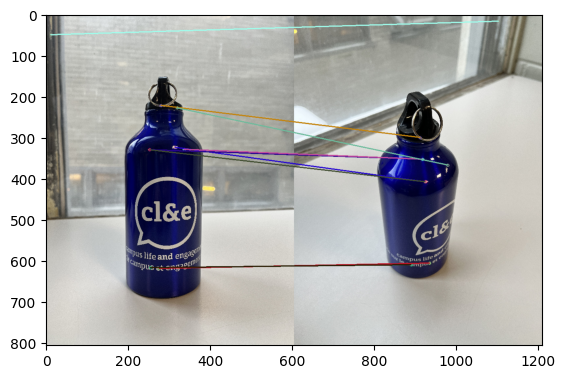

In [12]:
img1 = cv2.imread(PATH + "/data/Q2/bottle1.jpg")
img2 = cv2.imread(PATH + "/data/Q2/bottle2.jpg")

#desizing for less computation
img1 = cv2.resize(img1, None, fx = 0.2, fy = 0.2)
img2 = cv2.resize(img2, None, fx = 0.2, fy = 0.2)

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

img1_smooth = cv2.GaussianBlur(img1_gray, (11,11), 0)
img2_smooth = cv2.GaussianBlur(img2_gray, (11,11), 0)

sift = cv2.xfeatures2d.SIFT_create()

#compute sift keypoints
keypoints1, descriptors1 = sift.detectAndCompute(img1_smooth,None)
keypoints2, descriptors2 = sift.detectAndCompute(img2_smooth,None)

#matching keypoints with brute-force method
bf_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf_matcher.match(descriptors1, descriptors2)

#sorting matching keypoints according to distance
matches = sorted(matches, key = lambda x:x.distance)

#get image of top ten matched keypoints
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:10], None, flags=2)

#changing match line thickness and color
for match in matches[:10]:
  pt1 = (int(keypoints1[match.queryIdx].pt[0]), int(keypoints1[match.queryIdx].pt[1]))
  pt2 = (int(keypoints2[match.trainIdx].pt[0] + img1.shape[1]), int(keypoints2[match.trainIdx].pt[1]))
  color = tuple(np.random.randint(0, 256, 3).tolist())
  cv2.line(img_matches, pt1, pt2, color, thickness=2)

plt.imshow(img_matches)

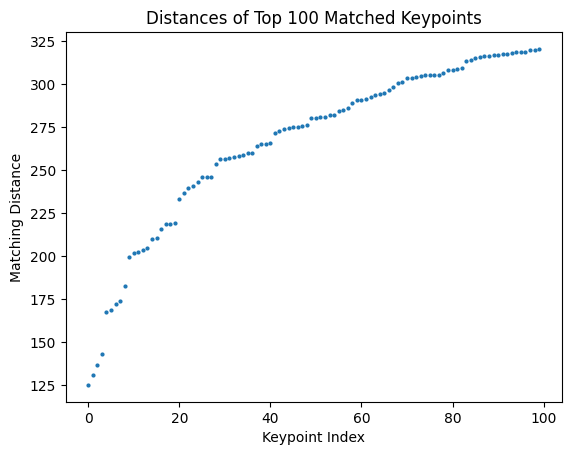

In [13]:
distances = []
for i in range(100):
  distances.append(matches[i].distance)

plt.plot(distances, "o", markersize=2)

plt.xlabel("Keypoint Index")
plt.ylabel("Matching Distance")
plt.title("Distances of Top 100 Matched Keypoints")
plt.show()

### 2.3 Invariance Under Scale


In [14]:
img1 = cv2.imread(PATH + "/data/Q2/bottle1.jpg")

#desizing for less computation
img1 = cv2.resize(img1, None, fx = 0.2, fy = 0.2)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img1_smooth = cv2.GaussianBlur(img1_gray, (11,11), 0)

height, width = img1_smooth.shape

sift = cv2.xfeatures2d.SIFT_create()

#compute sift keypoints
keypoints1, descriptors1 = sift.detectAndCompute(img1_smooth,None)


scaled_images = [] #stores 4 pairs (gray and color) of images scaled differently
scale_factors = [0.25, 0.6, 3, 5]

#scaling img1 with different factors
for scale_factor in scale_factors:
  new_height = int(height * scale_factor)
  new_width = int(width * scale_factor)
  scaled_img_gray = cv2.resize(img1_smooth, (new_width, new_height))
  scaled_img_color = cv2.resize(img1, (new_width, new_height))
  scaled_images.append([scaled_img_gray, scaled_img_color])

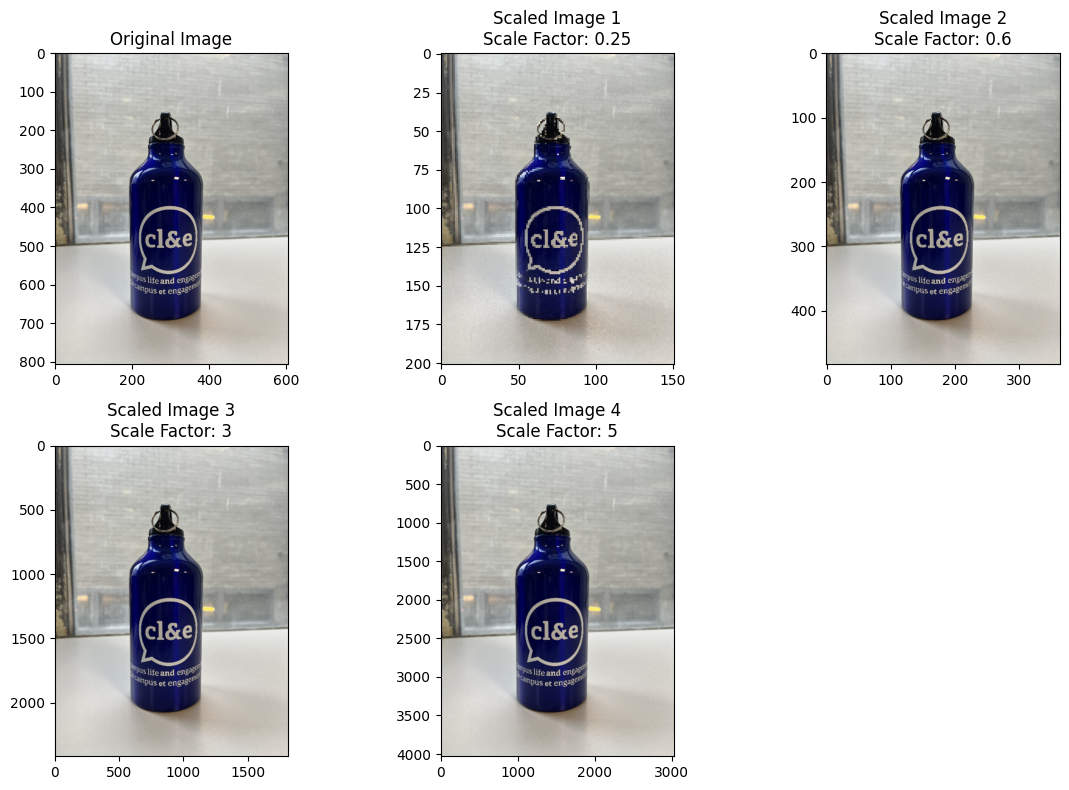

In [15]:
plt.figure(figsize=(12, 8))

#plotting the original image
plt.subplot(2, 3, 1)
plt.imshow(img1)
plt.title("Original Image")

#plotting the scaled images
for i, scaled_image in enumerate(scaled_images):
    plt.subplot(2, 3, i + 2)
    plt.imshow(scaled_image[1]) #displaying the color image
    plt.title(f"Scaled Image {i + 1}\nScale Factor: {scale_factors[i]}")

plt.tight_layout()
plt.show()

In [16]:
sift_list = [] #stores 4 pairs of keypoints and descriptors
sift = cv2.xfeatures2d.SIFT_create()

#compute sift keypoints
for scaled_image in scaled_images:
  keypoints, descriptors = sift.detectAndCompute(scaled_image[0], None)
  sift_list.append([keypoints, descriptors])


match_list = [] #stores distance sorted matches of keypoints
bf_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

#matching keypoints and sorting them according to distance
for sift in sift_list:
  matches = bf_matcher.match(descriptors1, sift[1])
  matches = sorted(matches, key = lambda x:x.distance)
  match_list.append(matches)

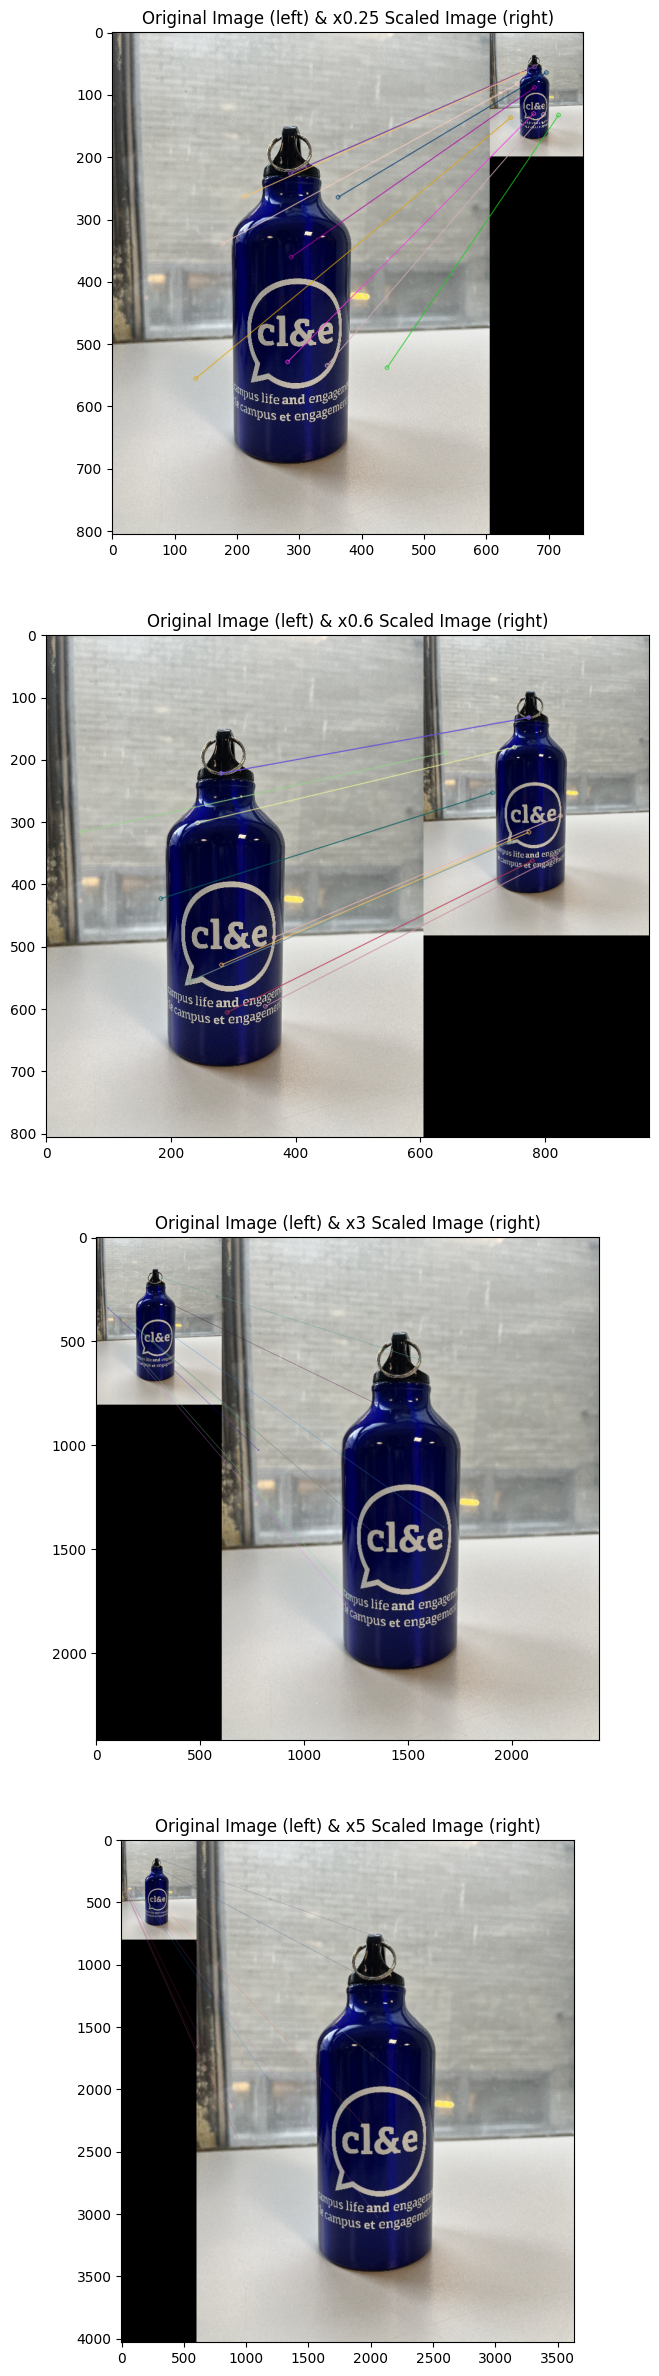

In [17]:
#plotting top ten matched keypoints for each pair of original image and scaled image
plt.figure(figsize=(30,30))
for i in range(4):
  img_matches = cv2.drawMatches(img1, keypoints1, scaled_images[i][1], sift_list[i][0], match_list[i][:10], None, flags=2)

  plt.subplot(4,1,i+1)
  plt.title(f"Original Image (left) & x{ scale_factors[i] } Scaled Image (right)")
  plt.imshow(img_matches)

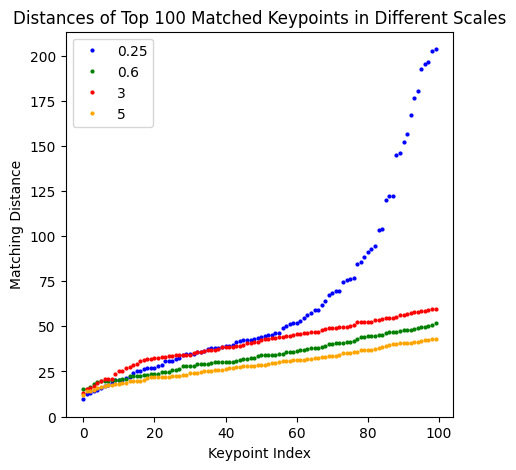

In [18]:
plt.figure(figsize=(5,5))
colors = ['blue', 'green', 'red', 'orange']

for i in range(4):
  distances = []
  for j in range(100):
    distances.append(match_list[i][j].distance)
  plt.plot(distances, "o", markersize=2, color=colors[i], label=scale_factors[i])

plt.xlabel("Keypoint Index")
plt.ylabel("Matching Distance")
plt.title("Distances of Top 100 Matched Keypoints in Different Scales")
plt.legend()
plt.show()

**Observations**

When looking at the top 60 matching keypoints, the different scaling has little effect on the matching distances, meaning that the SIFT algorithm is invariant to scaling to a certain extent. However, we can see that the graph of 0.25 scaled image increases rapidly after around the 60th keypoint. This may be due to the loss of pixel information when scaling the image, where the DoG pyramid cannot be generated with sufficient depth and the algorithm becomes variant in scaling.

### 2.4 Invariance Under Rotation

In [19]:
img1 = cv2.imread(PATH + "/data/Q2/bottle1.jpg")
img1 = cv2.resize(img1, None, fx = 0.2, fy = 0.2) #desize for less computation
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img1_smooth = cv2.GaussianBlur(img1_gray, (11,11), 0)

sift = cv2.xfeatures2d.SIFT_create()
#compute sift keypoints
keypoints1, descriptors1 = sift.detectAndCompute(img1_smooth, None)

height, width = img1_smooth.shape
rotated_images = [] #stores 4 pairs (gray and color) of rotated images
angles = [30, 75, 90, 180]
for angle in angles:
  rotation_matrix = cv2.getRotationMatrix2D((width//2, height//2), angle, 1)
  rotated_img_gray = cv2.warpAffine(img1_smooth, rotation_matrix, (width, height))
  rotated_img_color = cv2.warpAffine(img1, rotation_matrix, (width, height))
  rotated_images.append([rotated_img_gray, rotated_img_color])

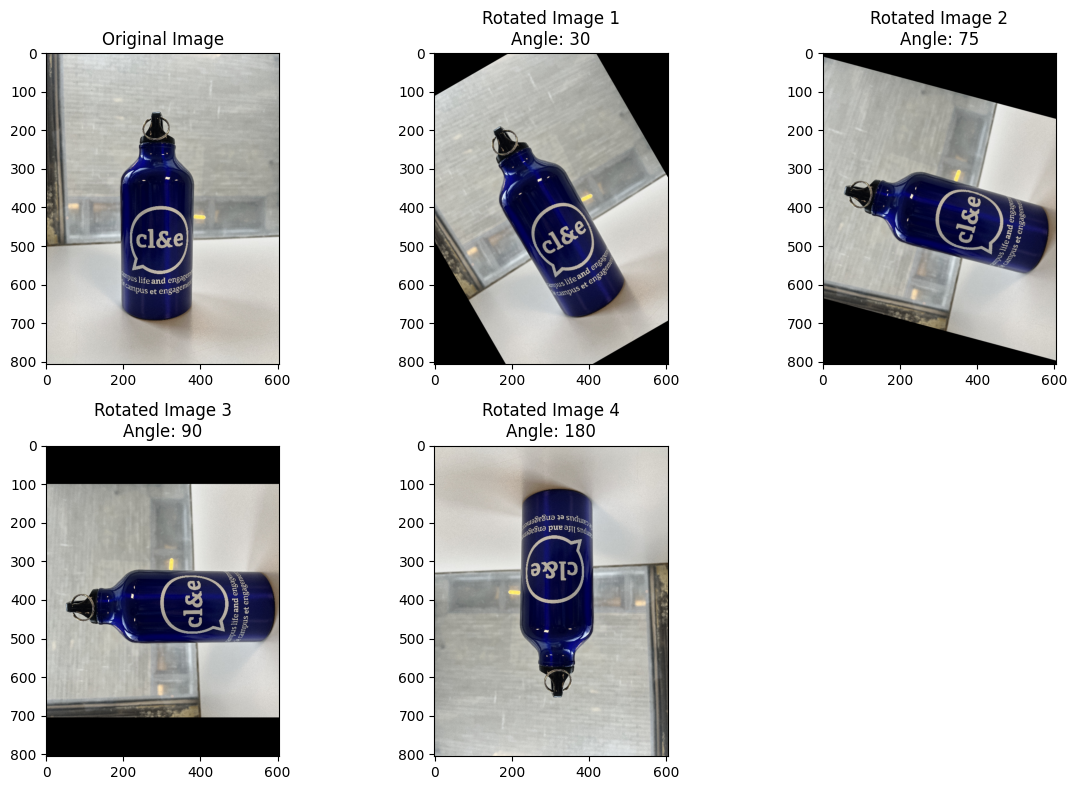

In [20]:
plt.figure(figsize=(12, 8))

#plotting the original image
plt.subplot(2, 3, 1)
plt.imshow(img1)
plt.title("Original Image")

#plotting the scaled images
for i, rotated_image in enumerate(rotated_images):
    plt.subplot(2, 3, i + 2)
    plt.imshow(rotated_image[1]) #displaying the color image
    plt.title(f"Rotated Image {i + 1}\nAngle: {angles[i]}")

plt.tight_layout()
plt.show()

In [21]:
sift_list = [] #stores 4 pairs of keypoints and descriptors with different rotation
sift = cv2.xfeatures2d.SIFT_create()

#compute sift keypoints
for rotated_image in rotated_images:
  keypoints, descriptors = sift.detectAndCompute(rotated_image[0], None)
  sift_list.append([keypoints, descriptors])


match_list = [] #stores distance sorted matches of keypoints
bf_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

#matching keypoints and sorting them according to distance
for sift in sift_list:
  matches = bf_matcher.match(descriptors1, sift[1])
  matches = sorted(matches, key = lambda x:x.distance)
  match_list.append(matches)

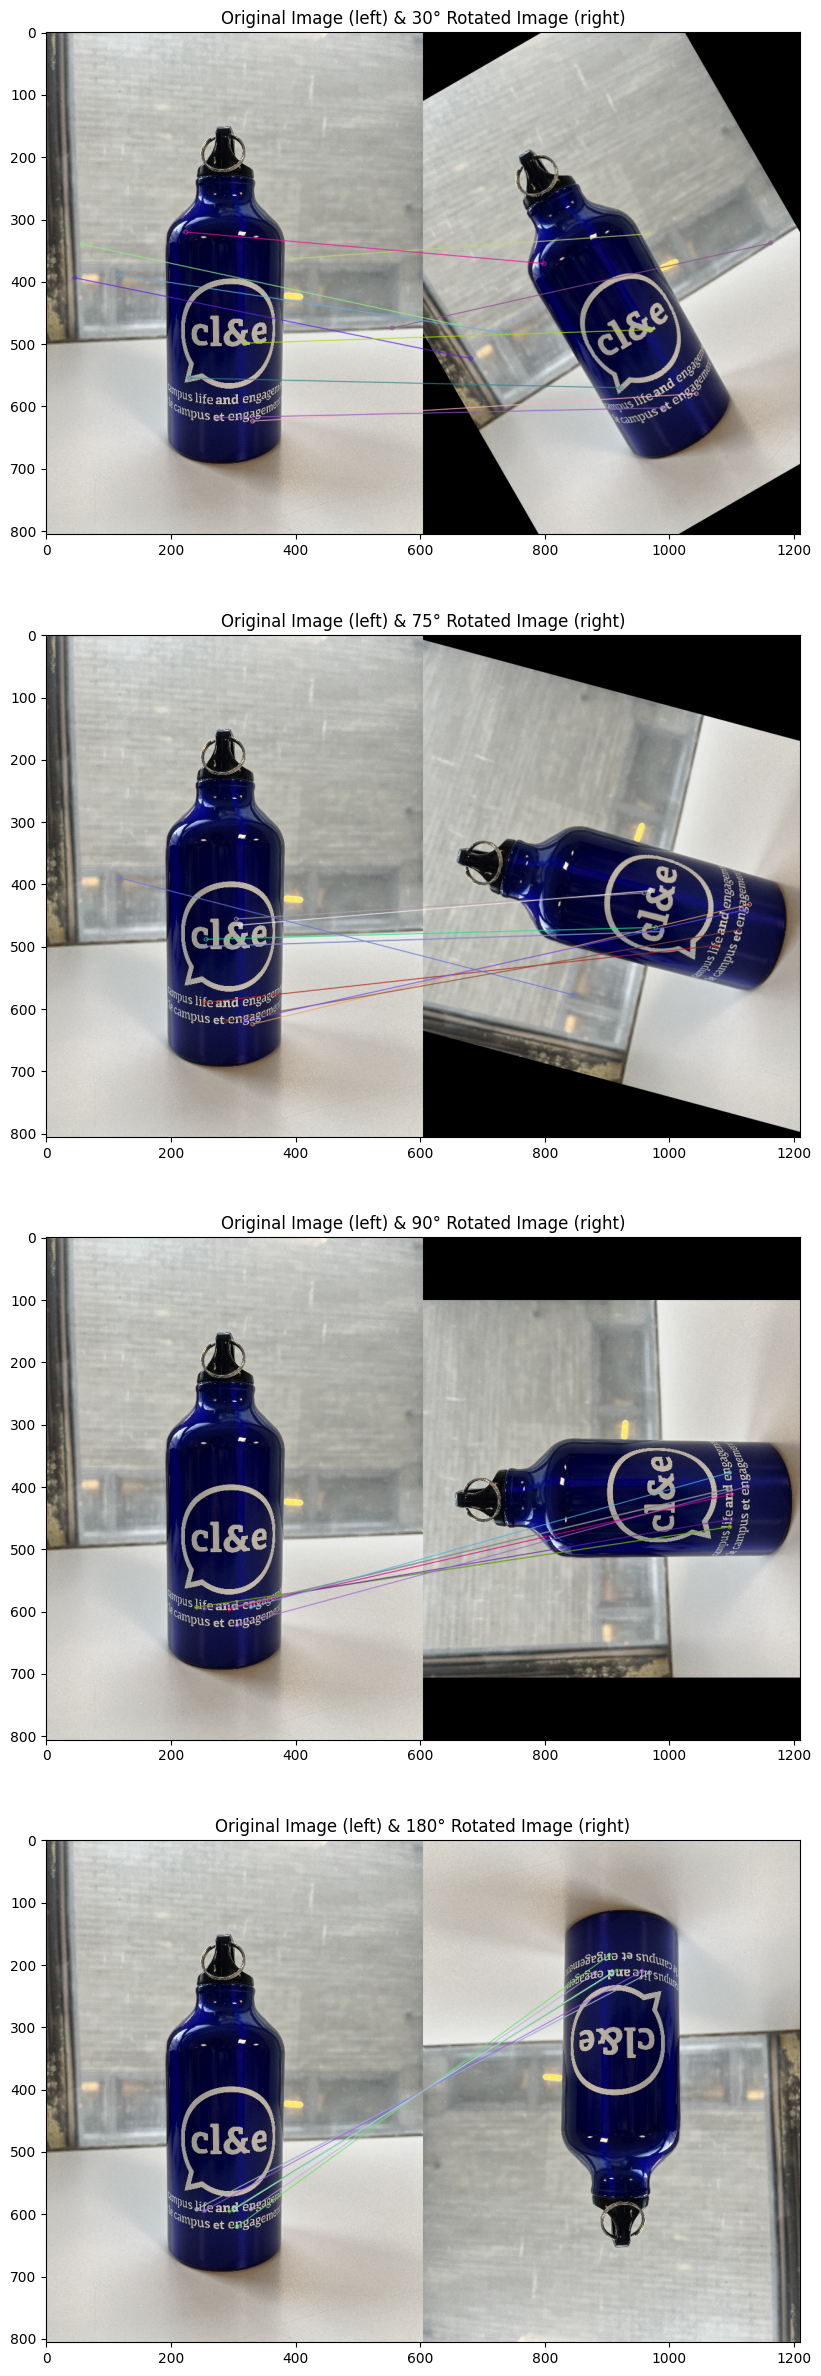

In [22]:
#plotting top ten matched keypoints for each pair of original image and rotated image
plt.figure(figsize=(30,30))
for i in range(4):
  img_matches = cv2.drawMatches(img1, keypoints1, rotated_images[i][1], sift_list[i][0], match_list[i][:10], None, flags=2)
  plt.subplot(4,1,i+1)
  plt.title(f"Original Image (left) & { angles[i] }° Rotated Image (right)")
  plt.imshow(img_matches)

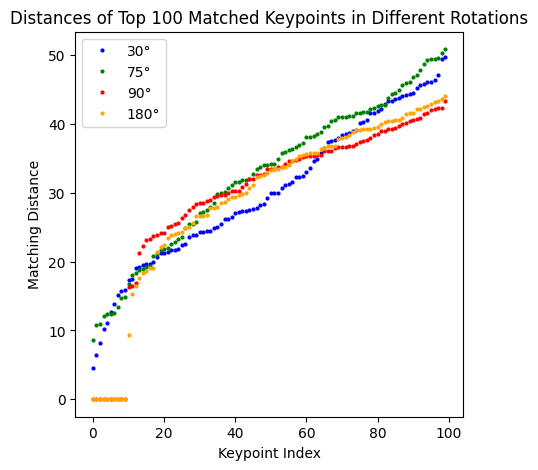

In [23]:
plt.figure(figsize=(5,5))
colors = ['blue', 'green', 'red', 'orange']

for i in range(4):
  distances = []
  for j in range(100):
    distances.append(match_list[i][j].distance)
  plt.plot(distances, "o", markersize=2, color=colors[i], label=str(angles[i])+"°")

plt.xlabel("Keypoint Index")
plt.ylabel("Matching Distance")
plt.title("Distances of Top 100 Matched Keypoints in Different Rotations")
plt.legend()
plt.show()

**Observations**

When looking from the 20th matched keypoints and on, the different rotation has little effect on the matching distances, meaning that the SIFT algorithm is invariant to orientation to a certain extent. However, we can see that the graph of 90 and 180 degree rotation stays zero for around the top 10 matching keypoints. This may be because the rotation by multiples of 90 degrees will not change the pixel values and only changes the orientation.

If this is the case, it is strange that not all the keypoints have distance 0 for the 90 and 180 degree rotated images, even though the original image and rotated images where both filtered with a Gaussian of same kerrnel size and σ before the rotation. Below is the graph when SIFT and keypoint matching is done on the image without a Gaussian filter. Here the distances for all top 100 matched keypoints were zero. The cause of this effect could not be found because even with the former method, the Gaussian filtering is only done once on the original image and the rotation is done on the original image afterwards.



##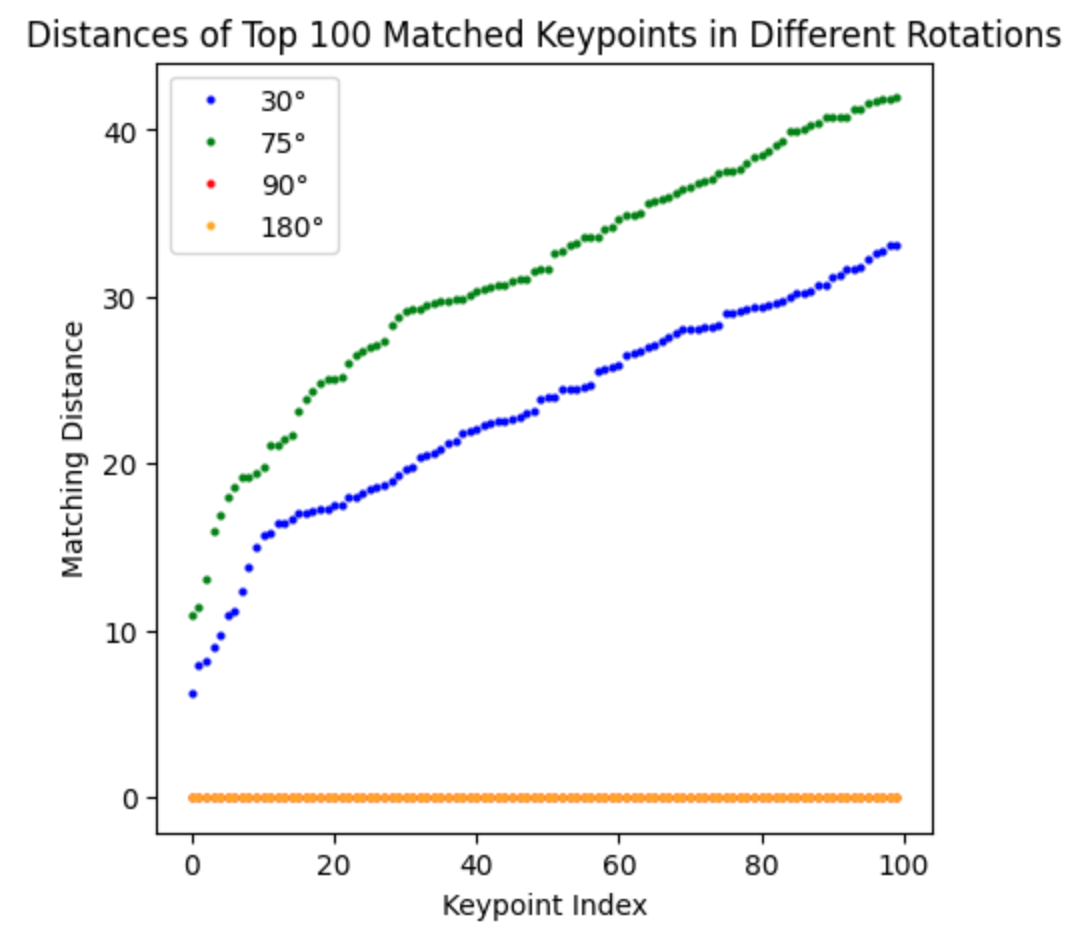

## 3 Image Stitching

When I tried to transform image_1 and warp it to match with image_2, the left half of image_1 was cut and the overlapping area of image_1 and image_2 was only shown. The instructions said that image_2 should not be transformed, therefore, I performed stitching by first making a margin on the left and right side of image_2 to give space for image_1 and image_3 to fit and not get cropped after transformation.



---



In [24]:
img1 = cv2.imread(PATH + "/data/Q3/part1.png")
img2 = cv2.imread(PATH + "/data/Q3/part2.png")
img3 = cv2.imread(PATH + "/data/Q3/part3.png")

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

#creating a large canvas and placing image_2 in the middle
img2_wide = np.zeros((img2.shape[0], img1.shape[1]+img2.shape[1]+img3.shape[1], 3), dtype=np.uint8)
img2_wide[:, img1.shape[1]:img1.shape[1]+img2.shape[1], :] = img2

img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
img2_gray = cv2.cvtColor(img2_wide, cv2.COLOR_RGB2GRAY)
img3_gray = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)

img1_smooth = cv2.GaussianBlur(img1_gray, (3,3), 0)
img2_smooth = cv2.GaussianBlur(img2_gray, (3,3), 0)
img3_smooth = cv2.GaussianBlur(img3_gray, (3,3), 0)

Stichting Images 1 and 2

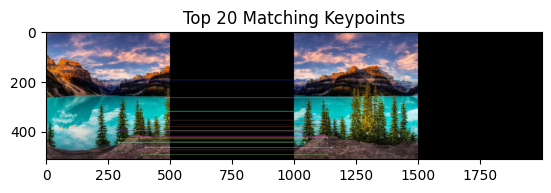

In [25]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(img1_smooth, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2_smooth, None)
bf_matcher12 = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches12 = bf_matcher12.knnMatch(descriptors1, descriptors2, k=2)

#ratio test is applied to remove ambiguous matches
good_matches = []
for m, n in matches12:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)

matched_image12 = cv2.drawMatches(img1, keypoints1, img2_wide, keypoints2, np.random.choice(good_matches, 20), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.title("Top 20 Matching Keypoints")
plt.imshow(matched_image12)

In [26]:
reprojection_thresh = 3 #set 1-10
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])
homography_matrix, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, reprojection_thresh)

img1_transformed = cv2.warpPerspective(img1, homography_matrix, (img2_wide.shape[1], img2_wide.shape[0]))
img12 = cv2.addWeighted(img1_transformed, 0.5, img2_wide, 0.5, 0) #brightness of certain areas is wrong because the black margins are also added weight

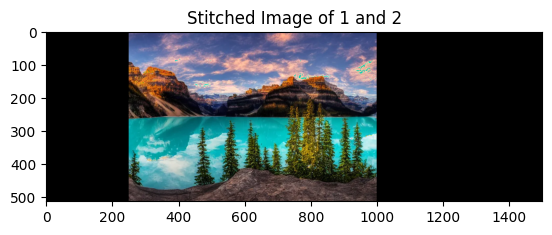

In [27]:
#corner coordinates of original image_1
tl1 = np.array([0, 0, 1])
bl1 = np.array([0, img1.shape[0], 1])
tr1 = np.array([img1.shape[1], 0, 1])
br1 = np.array([img1.shape[1], img1.shape[0], 1])

#corner coordinates of warped image_1
tl1_new = np.round(homography_matrix @ tl1)
bl1_new = np.round(homography_matrix @ bl1)
tr1_new = np.round(homography_matrix @ tr1)
br1_new = np.round(homography_matrix @ br1)

#corner coordinates of original image_2
tl2 = np.array([img1.shape[1], 0, 1])
bl2 = np.array([img1.shape[1], img2.shape[0], 1])
tr2 = np.array([img1.shape[1]+img2.shape[1], 0, 1])
br2 = np.array([img1.shape[1]+img2.shape[1], img2.shape[0], 1])

#brightness of certain areas are fixed
img12[:, int(tl1_new[0]):int(tl2[0]), :] *= 2
img12[:, int(tr1_new[0]):int(tr2[0]), :] *= 2

plt.title("Stitched Image of 1 and 2")
plt.imshow(img12)



---



Stichting Images 12 and 3

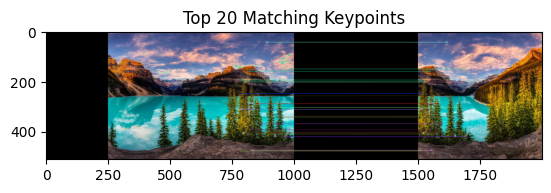

In [28]:
img12_gray = cv2.cvtColor(img12, cv2.COLOR_RGB2GRAY)
keypoints12, descriptors12 = sift.detectAndCompute(img12_gray, None)
keypoints3, descriptors3 = sift.detectAndCompute(img3_smooth, None)
bf_matcher123 = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches123 = bf_matcher123.knnMatch(descriptors12, descriptors3, k=2)

#ratio test is applied to remove ambiguous matches
good_matches = []
for m, n in matches123:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)

matched_image123 = cv2.drawMatches(img12, keypoints12, img3, keypoints3, np.random.choice(good_matches, 20), None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.title("Top 20 Matching Keypoints")
plt.imshow(matched_image123)

In [29]:
reprojection_thresh = 3 #set 1-10
pts12 = np.float32([keypoints12[m.queryIdx].pt for m in good_matches])
pts3 = np.float32([keypoints3[m.trainIdx].pt for m in good_matches])
homography_matrix, mask = cv2.findHomography(pts3, pts12, cv2.RANSAC, reprojection_thresh)

img3_transformed = cv2.warpPerspective(img3, homography_matrix, (img12.shape[1], img12.shape[0]))
img123 = cv2.addWeighted(img3_transformed, 0.5, img12, 0.5, 0) #brightness of certain areas is wrong because the black margins are also added weight

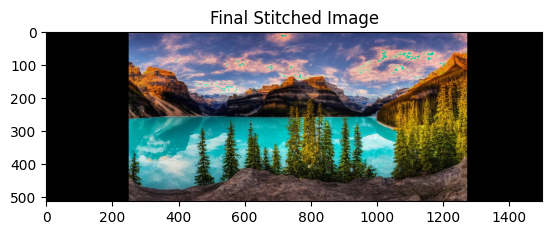

In [30]:
#corner coordinates of original image_3
tl3 = np.array([0, 0, 1])
bl3 = np.array([0, img3.shape[0], 1])
tr3 = np.array([img3.shape[1], 0, 1])
br3 = np.array([img3.shape[1], img3.shape[0], 1])

#corner coordinates of warped image_3
tl3_new = np.round(homography_matrix @ tl3)
bl3_new = np.round(homography_matrix @ bl3)
tr3_new = np.round(homography_matrix @ tr3)
br3_new = np.round(homography_matrix @ br3)

#brightness of certain areas are fixed
img123[:, int(tl1_new[0]):int(tl3_new[0]), :] *= 2
img123[:, int(tr2[0]):int(tr3_new[0]), :] *= 2

plt.title("Final Stitched Image")
plt.imshow(img123)



---



**When should we prefer pyramid blending over linear blending?**

For this assignment, linear blending was good enough because the overlapping regions were very similar to each other. I assumed that this wide image was initially taken and where split (with overlap) in 3 smaller images, so that the stitching task was kept simple. However in real life cases, where the overlapping regions between images contain different lighting or textures, pyramid blending can provide better results by blending at multiple resolutions. This can prevent apparent seams and ghosting effects. Whenever we want to achieve seamless and natural transitions, we should go with pyramid blending.

## 4. References



1.   Harris Corner Detector
  * https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

2.   SIFT
  * https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html
  * https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html

3.   Feature Matching
  * https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html

4.   Homography
  * https://learnopencv.com/homography-examples-using-opencv-python-c/
  * https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

